<a href="https://colab.research.google.com/github/lhonorio/New-Repository/blob/main/CSE450FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import altair as alt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/lhonorio/New-Repository/main/datatraining.csv")

df.head()

,i,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2/4/2015 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2,2/4/2015 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,3,2/4/2015 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,4,2/4/2015 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,5,2/4/2015 17:55,23.10,27.2000,426.0,704.50,0.004757,1


# Preprocessing

In [3]:
# df.dtypes

df[['date','time']] = df['date'].str.split(' ',expand=True)

In [4]:
df['date'] = df['date'].astype('datetime64')

In [5]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [6]:
df['hour'] = df['time'].str[:2]

In [7]:
df[['hour','minutes']] = df['time'].str.split(':',expand=True)
df['hour'] = df['hour'].astype('float64')
df['minutes'] = df['minutes'].astype('float64')

df['minutes'] = df['minutes'] / 60
df['hour'] = round((df['hour'] + df['minutes']), 0)
df['hour'] = df['hour'].astype('int64')

# Because all the data was gathered on February 2015, I decided to also drop the year and month column
df = df.drop(columns= {'time','minutes', 'i', 'year', 'month'}, axis=1)

In [8]:
# Heat Index = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
df['heat_index'] = -42.379 + 2.04901523*df['Temperature'] + 10.14333127*df['HumidityRatio'] - .22475541*df['Temperature']*df['HumidityRatio'] - .00683783*df['Temperature']*df['Temperature'] - .05481717*df['HumidityRatio']*df['HumidityRatio'] + .00122874*df['Temperature']*df['Temperature']*df['HumidityRatio'] + .00085282*df['Temperature']*df['HumidityRatio']*df['HumidityRatio'] - .00000199*df['Temperature']*df['Temperature']*df['HumidityRatio']*df['HumidityRatio']

In [9]:
#df.describe()
df.head()
#df['Occupancy'].value_counts()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,hour,heat_index
0,2015-02-04,23.18,27.2720,426.0,721.25,0.004793,1,18,1.469932
1,2015-02-04,23.15,27.2675,429.5,714.00,0.004783,1,18,1.417936
2,2015-02-04,23.15,27.2450,426.0,713.50,0.004779,1,18,1.417914
3,2015-02-04,23.15,27.2000,426.0,708.25,0.004772,1,18,1.417869
4,2015-02-04,23.10,27.2000,426.0,704.50,0.004757,1,18,1.331190


# Training

In [10]:
# Encode our features and target as needed
features = [f for f in df if f != 'Occupancy' if f != 'date']

X = df[features]
y = df['Occupancy']

# Split our data into training and test data, with 20% reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Testing

In [11]:
# Build the decision tree
clf = DecisionTreeClassifier(random_state = 42)
#clf = RandomForestRegressor(random_state = 42, n_estimators=500, max_depth=4)
#clf =DecisionTreeClassifier(criterion="gini", random_state=42, min_samples_leaf=5)
# model = XGBRegressor(
#     n_estimators= 150, # Default is 100
#     learning_rate= .15, # default = .1
#     grow_policy='lossguide', # Options are 'depthwise' and 'lossguide'
#     tree_method = 'auto', # Options are 'approx', 'auto', 'exact', 'gpu_exact', 'gpu_hist', 'hist'
# )

# Train it
clf.fit(X_train, y_train)

# Test it 
print(f"Score = {clf.score(X_test, y_test)}")

# Note that this gives us an accuracy score, which may not be the best metric.
# See the SciKit-Learn docs for more ways to assess a model's performance, as
# well as methods for cross validation.

Score = 0.994475138121547


In [12]:
predictions = clf.predict(X_test)

result = pd.DataFrame(predictions, columns = ['y'])
#result['y'] = result['y'].map({'yes': 1, 'no': 0})

# Test it 
mean_average = clf.score(X_test, y_test)

In [13]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1286
           1       0.99      0.99      0.99       343

    accuracy                           0.99      1629
   macro avg       0.99      0.99      0.99      1629
weighted avg       0.99      0.99      0.99      1629



# Features Importance

<Axes: xlabel='importance', ylabel='features'>

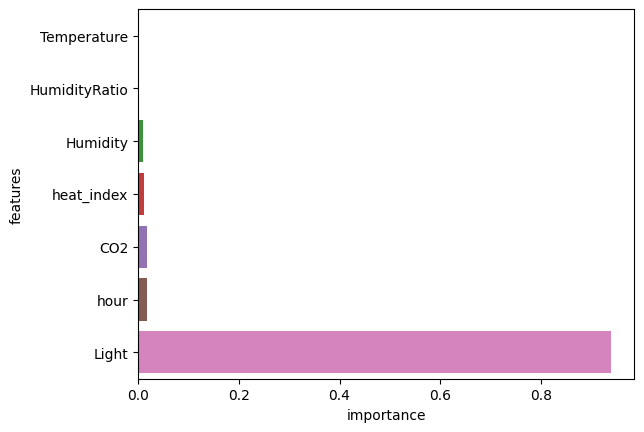

In [14]:
feature_df = pd.DataFrame({'features':X.columns, 'importance':clf.feature_importances_})
feature_df = feature_df.sort_values('importance')

sns.barplot(data=feature_df, x="importance", y="features", order=feature_df.sort_values('importance').features)

In [15]:
feature_df

,features,importance
0,Temperature,0.001865
4,HumidityRatio,0.002455
1,Humidity,0.010541
6,heat_index,0.011716
3,CO2,0.017030
5,hour,0.017985
2,Light,0.938409
